In [125]:
import pandas as pd
from os import listdir
from pandas.errors import EmptyDataError
from unidecode import unidecode
import seaborn as sns
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt

sns.set(
    rc = {
        'figure.figsize': (10, 8)
    },
    style = 'darkgrid'
)

# Read data

## Wyborcza

In [2]:
wyborcza_articles = []
for filename in listdir('data/wyborcza/articles'):
    wyborcza_articles.append(pd.read_csv('data/wyborcza/articles/'+filename, header = None))
wyborcza_articles = pd.concat(wyborcza_articles)
wyborcza_articles.columns = ['url', 'title', 'short', 'long', 'img', 'com']
wyborcza_articles['short'] = wyborcza_articles['short'].str.replace(r'(.|..)\n', '')
wyborcza_articles['website'] = 'wyborcza'
wyborcza_articles['brand'] = 'agora'
wyborcza_articles['country'] = 'pl'

In [3]:
wyborcza_articles.head(3)

,url,title,short,long,img,com,website,brand,country
0,"https://poznan.wyborcza.pl/poznan/1,36001,2078...",Czarny protest w Poznaniu. Policja interweniow...,"2Po czarnym proteście na placu Mickiewicza, tł...",W czarnym proteście na pl. Mickiewicza pod pom...,3 października 2016 r. Po 'czarnym proteście' ...,"Policjanci! Na ulicę wyszły wasze żony,siostry...",wyborcza,agora,pl
1,"https://wyborcza.pl/1,155287,7439653,Zdecydowa...",Zdecydowana większość newsów pochodzi z gazet,Z badań przeprowadzonych przez Pew Research Ce...,Choć rośnie liczba źródeł wiadomości na platfo...,NaN,NaN,wyborcza,agora,pl
2,"https://lodz.wyborcza.pl/lodz/7,35136,23016701...","Gwiazdy na łódzkiej premierze filmu ""Pomiędzy ...",Łódź filmowa doczekała się kolejnej premiery. ...,"""Pomiędzy słowami"" to ostatni film Urszuli An...",MARCIN STĘPIEŃ,NaN,wyborcza,agora,pl


## Gazeta

In [4]:
gazeta_articles = []
for filename in listdir('data/gazeta/articles'):
    try:
        gazeta_articles.append(pd.read_csv('data/gazeta/articles/'+filename, header = None))
    except EmptyDataError:
        pass # empty file
gazeta_articles = pd.concat(gazeta_articles)
gazeta_articles.columns = ['url', 'title', 'short', 'long', 'img', 'com']
gazeta_articles['website'] = 'gazeta'
gazeta_articles['brand'] = 'agora'
gazeta_articles['country'] = 'pl'

In [5]:
gazeta_articles.head(3)

,url,title,short,long,img,com,website,brand,country
0,http://metrowarszawa.gazeta.pl/metrowarszawa/7...,Warszawa. Będą dwie nowe stacje na I linii met...,"Ratusz podpisał umowę z firmą Metroprojekt, kt...","""Jak zapowiadałem w kampanii wyborczej pracuje...",Fot. Urząd Miasta Warszawa,"Najpierw powinna powstać III linia, a dopiero ...",gazeta,agora,pl
1,"http://wiadomosci.gazeta.pl/wiadomosci/1,11487...",Prezydent Duda w Paryżu o uchodźcach: Pomagać ...,Wsparcie finansowe dla uchodźców zapowiedział ...,Chcesz wiedzieć szybciej? Polub nas\n- Trzeba ...,Fot. Prezydent.pl,Brawo Duda. Trzeba opieprzyć tych baranów z za...,gazeta,agora,pl
2,"http://podroze.gazeta.pl/podroze/7,114158,2496...","Grecy szukają osób, które zgodziłyby się zamie...","Jeśli kiedykolwiek marzyłeś o tym, aby zamiesz...",Andikitira to grecka wyspa zaliczana do Wysp J...,fot. Shutterstock,Lepsze jest 500€ niż pincetplus.\nJadę!-@@@-Ta...,gazeta,agora,pl


## Add keywords to wyborcza and gazeta

In [6]:
listdir('data/wyborcza_gazeta/urls')

['duda',
 'premier',
 'kwa%B6niewski',
 'imigranci',
 'lgbt',
 'bank',
 'ko%B6ci%F3%B3',
 'rydzyk',
 'feminizm',
 'emigracja',
 'lewica',
 'prezydent',
 'trump',
 'kaczy%F1ski',
 'pis',
 'stany',
 's%B1d+najwy%BFszy',
 'prawica',
 'sejm',
 'szyd%B3o',
 'ukraina',
 'opozycja',
 'polska',
 'leszek+miller',
 'rosja',
 'unia+europejska',
 'platforma',
 'rz%B1d',
 'niemcy',
 'media',
 'morawiecki',
 'putin',
 'papie%BF',
 'korwin',
 'ekologia']

In [7]:
decoder = {
    '%B1': 'ą',
    '%BF': 'ż',
    '%B3': 'ł',
    '%B6': 'ś',
    '%F1': 'ń',
    '%F3': 'ó'
}

In [8]:
keyword_urls = {}
keywords = []
for filename in listdir('data/wyborcza_gazeta/urls'):
    with open('data/wyborcza_gazeta/urls/'+filename, 'r') as f:
        urls = [x for x in f.read().split('\n') if 'gazeta.pl' in x or 'wyborcza.pl' in x]
        for key in decoder.keys():
            filename = filename.replace(key, decoder[key])
        keyword_urls[filename] = urls
        keywords.append(filename)

In [9]:
keywords_df = pd.concat([
    pd.DataFrame(
        pd.Series([1 for x in keyword_urls[key]], name = key, index = keyword_urls[key]),
    ) for key in keyword_urls.keys()  
], axis = 1, sort = False).fillna(0)

In [10]:
len(wyborcza_articles)

18738

In [11]:
wyborcza_articles = pd.merge(
    wyborcza_articles, 
    keywords_df, 
    left_on = 'url', 
    right_on = keywords_df.index
)

In [12]:
len(wyborcza_articles)

18564

In [13]:
len(gazeta_articles)

3940

In [14]:
gazeta_articles = pd.merge(
    gazeta_articles, 
    keywords_df, 
    left_on = 'url', 
    right_on = keywords_df.index
)

In [15]:
len(gazeta_articles)

3898

## Fakt

In [16]:
# fakt_articles = []
# for filename in listdir('data/fakt/articles'):
#     fakt_articles.append(pd.read_csv('data/fakt/articles/'+filename, header = None))
# fakt_articles = pd.concat(fakt_articles)

In [17]:
# fakt_articles.iloc[1].values

## Concentrate data

In [18]:
df = pd.concat([
    wyborcza_articles,
    gazeta_articles,
], axis = 0, sort = False)

# Analyze

## Get emotions data from polish wordnet

In [19]:
# http://plwordnet.pwr.wroc.pl//wordnet/download-wordnet?key=1iflsj&file=4.0
# extract one file (słownik_anotacji_emocjonlanej) to home directory

In [20]:
emotions = pd.read_csv('~/słownik_anotacji_emocjonlanej.csv')[['lemat', 'emocje']].dropna()

In [21]:
emotions.head()

,lemat,emocje
2,abstrakcyjny,wstręt;złość;zaskoczenie
3,abstrakcyjny,wstręt;złość
10,adorator,złość;radość
11,adorator,złość;cieszenie się na;radość;wstręt
18,afektowany,złość;smutek


In [22]:
emotions['emocje'] = emotions['emocje'].str.replace(':', ';')

In [23]:
pairs = [
    ('złosć', 'negatywny'),
    ('zlość', 'negatywny'),
    ('złośc', 'negatywny'),
    ('złość wstręt', 'negatywny'),
    ('złość: nieużyteczność', 'negatywny'),
    ('złóść', 'negatywny'),
    ('bład', 'negatywny'),
    ('brzydota', 'negatywny'),
    ('błąd', 'negatywny'),
    ('gniew', 'negatywny'),
    ('krzywda', 'negatywny'),
    ('nieszczęscie', 'negatywny'),
    ('nieszczęście', 'negatywny'),
    ('nieużyteczność', 'negatywny'),
    ('złość', 'negatywny'),
    ('strach', 'negatywny'),
    ('strach wstręt', 'negatywny'),
    ('smute', 'negatywny'),
    ('smutek', 'negatywny'),
    ('wstęt', 'negatywny'),
    ('niewiedza', 'negatywny'),
    ('negatywny wstręt', 'negatywny'),
    ('negatywnyk', 'negatywny'),
    ('negatywnyk: negatywny', 'negatywny'),
    ('wstrę', 'negatywny'),
    ('wstręt', 'negatywny'),
    ('wstręt: negatywny', 'negatywny'),
    ('negatywnyt', 'negatywny'),
    ('s mutek', 'negatywny'),
    ('wstret', 'negatywny'),
    ('smitek', 'negatywny'),
    (' negatywny', 'negatywny'),
    
    ('cieszenie sie', 'pozytywny'),
    ('cieszenie sie na', 'pozytywny'),
    ('cieszenie się na coś oczekiwanego', 'pozytywny'),
    ('dobro', 'pozytywny'),
    ('cieszenie sie', 'pozytywny'),
    ('radoć', 'pozytywny'),
    ('radość', 'pozytywny'),
    ('radość: piękno', 'pozytywny'),
    ('radość: szczęście', 'pozytywny'),
    ('zaufanie', 'pozytywny'),
    ('cieszenie się', 'pozytywny'),
    ('cieszenie się na', 'pozytywny'),
    ('ciesznie się na', 'pozytywny'),
    ('piękno', 'pozytywny'),
    ('pozytywny: piękno', 'pozytywny'),
    ('pozytywny: szczęście', 'pozytywny'),
    ('prawda', 'pozytywny'),
    ('radosć', 'pozytywny'),
    ('pozytywny: pozytywny', 'pozytywny'),
    ('radośc', 'pozytywny'),
    ('szczęście', 'pozytywny'),
    ('użyteczność', 'pozytywny'),
    ('wiedza', 'pozytywny'),
    ('zufanie', 'pozytywny'),
    ('pozytywny na', 'pozytywny'),
    (' pozytywny', 'pozytywny'),
    
    ('zaskoczenie czymś nieprzewidywanym', ''),
    ('oczekiwanie na', ''),
    (' czymś nieprzewidywanym', ''),
    ('-', ''),
    ('zaskoczenie', ''),
    ('pozytywnynegatywny', ''),
]

In [24]:
for pair in pairs:
    emotions['emocje'] = emotions['emocje'].str.replace(pair[0], pair[1])

In [25]:
emotions = pd.concat([
    emotions['lemat'],
    emotions['emocje']\
        .str.get_dummies(sep = ';')\
], axis = 1)

In [26]:
emotions.loc[
    emotions['pozytywny'] == emotions['negatywny']
, 'ambiguous'] = True

In [27]:
len(emotions)

56420

In [28]:
emotions = emotions[emotions['ambiguous'].isna()]
emotions = emotions.drop('ambiguous', axis = 1)

In [29]:
len(emotions)

47477

In [30]:
emotions['negatywny'].sum()

31505

In [31]:
emotions['pozytywny'].sum()

15972

In [32]:
emotions.sample(5).head()

,lemat,negatywny,pozytywny
144093,niedługi,1,0
37511,fioł,1,0
32245,chuligaństwo,1,0
49429,wyjałowić,1,0
73354,cherlactwo,1,0


In [33]:
emotions = emotions.drop('negatywny', axis = 1)

In [34]:
emotions.loc[emotions['pozytywny'] == 0, 'pozytywny'] = -1

In [35]:
emotions.columns = ['lemat', 'sentyment']

In [36]:
emotions = emotions.drop_duplicates()

In [37]:
emotions.sample(5).head()

,lemat,sentyment
155591,superowo,1
45527,klasycyzm,1
13490,możliwy,1
8099,wolna ręka,1
1359,dwuznaczny,-1


In [38]:
emotions_dict = {x[0]:x[1] for x in emotions.values}

## Titles/shorts

In [39]:
emotions.sample(5).head()

,lemat,sentyment
106027,bękarctwo,-1
73995,szelmowski,-1
21517,tułacz,-1
158774,wypijać,-1
43200,dupek,-1


In [40]:
emotion_words = emotions_dict.keys()

In [41]:
# title, short, long

In [42]:
df['sentiment'] = df['short'].str.lower().apply(lambda x: sum([emotions_dict[a] 
                                         for a in str(x).split(' ')
                                         if a in emotion_words]))

In [43]:
df[df['feminizm'] == 1][['website', 'sentiment']]

,website,sentiment
21,wyborcza,-1
198,wyborcza,0
253,wyborcza,1
364,wyborcza,0
1708,wyborcza,0
...,...,...
16488,wyborcza,0
18031,wyborcza,1
18407,wyborcza,1
3056,gazeta,0


In [65]:
data_dict = {}
for keyword in keywords:
    data_dict[keyword] = df\
        [(df[keyword] == 1)&(df['sentiment'] != 0)]\
        [['website', 'sentiment']]\
        .groupby(['website'])\
        .mean()\
        .values\
        .flatten()

In [66]:
res = pd.DataFrame().from_dict(
    data_dict,
    'index',
    columns = ['gazeta', 'wyborcza']
)

In [67]:
res.head(3)

,gazeta,wyborcza
duda,0.092105,0.159159
premier,0.523810,0.287879
kwaśniewski,-0.107143,0.333333


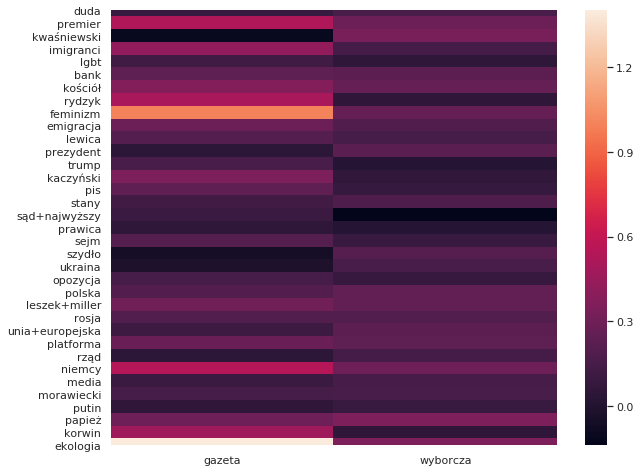

In [68]:
sns.heatmap(res);

In [69]:
res[res.index == 'feminizm']

,gazeta,wyborcza
feminizm,1.0,0.264706


In [ ]:
# compare that chart (two websites in one company), and two websites from two different companies

## Regex

In [ ]:
wc = WordCloud()

In [100]:
keyword_patterns = ['duda', 'dudy', 'dude']

In [101]:
found_records = df[['long']][
    df['long'].str.lower().str.contains(r'|'.join(keyword_patterns)) == True
].values.flatten()

In [119]:
keyword_words_before = []
keyword_words_after = []
for record in found_records:
    tmp_string_list = re.sub(r'\W+', ' ', record).lower().split(' ')
    keyword_idxs = [n for n, x in enumerate(tmp_string_list) if x in keyword_patterns]
    max_idx = len(tmp_string_list)
    for keyword_idx in keyword_idxs:
        if keyword_idx < max_idx - 2 and keyword_idx > 1:
            keyword_context_before = tmp_string_list[keyword_idx-2 : keyword_idx]
            keyword_words_before.append(keyword_context_before[0])
            keyword_words_before.append(keyword_context_before[1])
            keyword_context_after = tmp_string_list[keyword_idx+1 : keyword_idx+3]
            keyword_words_after.append(keyword_context_after[0])
            keyword_words_after.append(keyword_context_after[1])

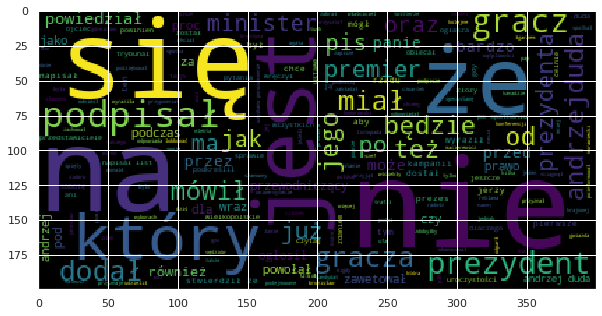

In [126]:
plt.imshow(wc.generate(" ".join(keyword_words_after)))

## Word2Vec